# Appling machine learning to audio analysis

## Trainning Code - Using cut audios of setA. No moving windows.

### Libraries

In [1]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [4]:
# To play audio file:
import IPython.display as ipd

In [5]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/negromontebs/seta/1c1d1228c6444e5080f9194fee1485d0



## MFCCs - Mel-Frequency Cepstrum Coefficients

### Function to extract the MFCCs from every file in our dataset

In [6]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name) 
    audio = shannonEnergy(audio)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    #mfccs_std = np.std(mfccs.T,axis=0)
    #mfccs_out = np.hstack((mfccs_processed, mfccs_std))
    mfccs_out = mfccs_processed
     
    return mfccs_out

In [7]:
# Shannon energy envelope method
def shannonEnergy(audio):
    audioShannon = []
    maxAudio = np.ndarray.max(audio)

    for i in audio:
        if i < 10**(-5):
            audioShannon.append(0)

        else:
            i = i/maxAudio
            energyS = -(i**2)*np.log10(i**2)
            audioShannon.append(energyS)

    audioPlot = np.array(audioShannon)
    meanShannon = np.mean(audioPlot)
    stdShannon = np.std(audioPlot)

    Power = []
    for i in audioPlot:
        Power.append((i - meanShannon)/stdShannon)

    powerPlot = np.array(audioShannon)
    return powerPlot

In [8]:
df = pd.read_csv('../csvFiles/newTiming.csv')

In [9]:
from os.path import exists

In [10]:
sounds = []# Iterate through each sound file and extract the sound type
cont = 0 # Counts how many files had their MFCCs analised
i = 0 # total number of files

for index, row in df.iterrows():
    file_name = df.loc[index]['fname']
    class_label = df.loc[index]['sound']
    
    if 'noise' in class_label:
        class_label = 'noise'
    
    #print(class_label)
    i+=1
    
    if (exists(file_name)):
        file_size = os.path.getsize(file_name)
        
        if (file_size > 44):
            data = extract_features(file_name)
            sounds.append([data, class_label])
            cont += 1
        else:
            # if the file is empty, it will print its name
            print(file_name)
            
n_mfccs = len(data)
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(sounds, columns=['soundtype','class_label'])

/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1750
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1751
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1222
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1122
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1888
  n_fft, y.shape[-1]
/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/librosa/core/spectrum.py:224

In [11]:
featuresdf
featuresdf.iloc[799]['class_label']
featuresdf.to_pickle('../MFCCs/cutA_toTrain_shannon_mfccs'+str(n_mfccs)+'.pkl') 

## Model building and training

### Load MFFCs from saved files

In [12]:
fileMFCCs = '../MFCCs/cutA_toTrain_shannon_mfccs'+str(n_mfccs)+'.pkl'
featuresdf = pd.read_pickle(fileMFCCs)

### Transform the data to arrays

In [13]:
keras.backend.clear_session()
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.soundtype.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

### Trainning and test sets

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

### Neural Network architecture

In [15]:
num_labels = yy.shape[1]

filter_size = 2

def build_model_graph(input_shape=(40,)):
    model = Sequential()
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 
    
    return model

model = build_model_graph()

# Display model architecture summary 
model(x_train)
model.summary()# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (640, 512)                20992     
_________________________________________________________________
activation (Activation)      (640, 512)                0         
_________________________________________________________________
dropout (Dropout)            (640, 512)                0         
_________________________________________________________________
dense_1 (Dense)              (640, 512)                262656    
_________________________________________________________________
activation_1 (Activation)    (640, 512)                0         
_________________________________________________________________
dropout_1 (Dropout)          (640, 512)                0         
_________________________________________________________________
dense_2 (Dense)              (640, 512)                2

### Model Trainning

In [16]:
num_epochs = 700
num_batch_size = 32

csv_logger = keras.callbacks.CSVLogger('../model_save/cut_setA_Train_shannon_mffcs'+str(n_mfccs)+'_Hist_'+str(num_epochs)+'.log')

model.fit(x_train, y_train, batch_size=num_batch_size,callbacks=[csv_logger], epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/700
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f96ab018818> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f96ab018818> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


COMET INFO: ignoring tensorflow summary log of metrics because of keras; set `comet_ml.loggers.tensorboard_logger.LOG_METRICS = True` to override


20/20 [==============================] - 9s 7ms/step - loss: 18.2232 - accuracy: 0.3875 - val_loss: 5.1821 - val_accuracy: 0.2500
Epoch 2/700
20/20 [==============================] - 0s 5ms/step - loss: 10.1824 - accuracy: 0.4219 - val_loss: 2.2843 - val_accuracy: 0.4625
Epoch 3/700
20/20 [==============================] - 0s 5ms/step - loss: 6.3345 - accuracy: 0.4297 - val_loss: 1.0431 - val_accuracy: 0.6438
Epoch 4/700
20/20 [==============================] - 0s 5ms/step - loss: 4.1592 - accuracy: 0.4656 - val_loss: 0.9483 - val_accuracy: 0.5813
Epoch 5/700
20/20 [==============================] - 0s 4ms/step - loss: 3.4787 - accuracy: 0.4484 - val_loss: 0.8293 - val_accuracy: 0.6000
Epoch 6/700
20/20 [==============================] - 0s 4ms/step - loss: 2.4721 - accuracy: 0.4594 - val_loss: 1.0795 - val_accuracy: 0.5375
Epoch 7/700
20/20 [==============================] - 0s 4ms/step - loss: 2.3750 - accuracy: 0.4344 - val_loss: 0.8603 - val_accuracy: 0.6375
Epoch 8/700
20/20 [====

Epoch 59/700
20/20 [==============================] - 0s 5ms/step - loss: 0.6098 - accuracy: 0.7156 - val_loss: 0.5681 - val_accuracy: 0.6812
Epoch 60/700
20/20 [==============================] - 0s 8ms/step - loss: 0.6073 - accuracy: 0.7203 - val_loss: 0.5217 - val_accuracy: 0.8062
Epoch 61/700
20/20 [==============================] - 0s 8ms/step - loss: 0.5739 - accuracy: 0.7203 - val_loss: 0.5132 - val_accuracy: 0.7750
Epoch 62/700
20/20 [==============================] - 0s 8ms/step - loss: 0.5913 - accuracy: 0.7063 - val_loss: 0.5379 - val_accuracy: 0.7563
Epoch 63/700
20/20 [==============================] - 0s 8ms/step - loss: 0.5532 - accuracy: 0.7484 - val_loss: 0.5156 - val_accuracy: 0.8062
Epoch 64/700
20/20 [==============================] - 0s 6ms/step - loss: 0.5168 - accuracy: 0.7594 - val_loss: 0.5187 - val_accuracy: 0.7750
Epoch 65/700
20/20 [==============================] - 0s 7ms/step - loss: 0.5574 - accuracy: 0.7609 - val_loss: 0.5079 - val_accuracy: 0.7688
Epoch 

20/20 [==============================] - 0s 8ms/step - loss: 0.4027 - accuracy: 0.8234 - val_loss: 0.4021 - val_accuracy: 0.8500
Epoch 117/700
20/20 [==============================] - 0s 8ms/step - loss: 0.3652 - accuracy: 0.8422 - val_loss: 0.3832 - val_accuracy: 0.8562
Epoch 118/700
20/20 [==============================] - 0s 7ms/step - loss: 0.3718 - accuracy: 0.8281 - val_loss: 0.4565 - val_accuracy: 0.8188
Epoch 119/700
20/20 [==============================] - 0s 6ms/step - loss: 0.3425 - accuracy: 0.8281 - val_loss: 0.4811 - val_accuracy: 0.8500
Epoch 120/700
20/20 [==============================] - 0s 8ms/step - loss: 0.3345 - accuracy: 0.8484 - val_loss: 0.4323 - val_accuracy: 0.8125
Epoch 121/700
20/20 [==============================] - 0s 8ms/step - loss: 0.3125 - accuracy: 0.8641 - val_loss: 0.4566 - val_accuracy: 0.8438
Epoch 122/700
20/20 [==============================] - 0s 8ms/step - loss: 0.3414 - accuracy: 0.8547 - val_loss: 0.4634 - val_accuracy: 0.8438
Epoch 123/700

20/20 [==============================] - 0s 6ms/step - loss: 0.2206 - accuracy: 0.9094 - val_loss: 0.5014 - val_accuracy: 0.8438
Epoch 174/700
20/20 [==============================] - 0s 6ms/step - loss: 0.2080 - accuracy: 0.9187 - val_loss: 0.4157 - val_accuracy: 0.8750
Epoch 175/700
20/20 [==============================] - 0s 6ms/step - loss: 0.2488 - accuracy: 0.9016 - val_loss: 0.5160 - val_accuracy: 0.8625
Epoch 176/700
20/20 [==============================] - 0s 6ms/step - loss: 0.2617 - accuracy: 0.8766 - val_loss: 0.4327 - val_accuracy: 0.8500
Epoch 177/700
20/20 [==============================] - 0s 6ms/step - loss: 0.2250 - accuracy: 0.9062 - val_loss: 0.4401 - val_accuracy: 0.8625
Epoch 178/700
20/20 [==============================] - 0s 6ms/step - loss: 0.2072 - accuracy: 0.9234 - val_loss: 0.5169 - val_accuracy: 0.8562
Epoch 179/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1981 - accuracy: 0.9219 - val_loss: 0.4803 - val_accuracy: 0.8625
Epoch 180/700

20/20 [==============================] - 0s 8ms/step - loss: 0.1381 - accuracy: 0.9359 - val_loss: 0.5397 - val_accuracy: 0.8625
Epoch 231/700
20/20 [==============================] - 0s 9ms/step - loss: 0.1317 - accuracy: 0.9516 - val_loss: 0.6375 - val_accuracy: 0.8500
Epoch 232/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1733 - accuracy: 0.9328 - val_loss: 0.5856 - val_accuracy: 0.8438
Epoch 233/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1669 - accuracy: 0.9312 - val_loss: 0.6926 - val_accuracy: 0.8562
Epoch 234/700
20/20 [==============================] - 0s 7ms/step - loss: 0.1625 - accuracy: 0.9391 - val_loss: 0.5357 - val_accuracy: 0.8438
Epoch 235/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1958 - accuracy: 0.9375 - val_loss: 0.6415 - val_accuracy: 0.8500
Epoch 236/700
20/20 [==============================] - 0s 8ms/step - loss: 0.2311 - accuracy: 0.9094 - val_loss: 0.6410 - val_accuracy: 0.8375
Epoch 237/700

20/20 [==============================] - 0s 6ms/step - loss: 0.1323 - accuracy: 0.9406 - val_loss: 0.6302 - val_accuracy: 0.8625
Epoch 288/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1015 - accuracy: 0.9563 - val_loss: 0.6954 - val_accuracy: 0.8500
Epoch 289/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1240 - accuracy: 0.9531 - val_loss: 0.6899 - val_accuracy: 0.8625
Epoch 290/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1503 - accuracy: 0.9328 - val_loss: 0.7649 - val_accuracy: 0.8313
Epoch 291/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1895 - accuracy: 0.9359 - val_loss: 0.7310 - val_accuracy: 0.8438
Epoch 292/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1694 - accuracy: 0.9328 - val_loss: 0.7512 - val_accuracy: 0.8250
Epoch 293/700
20/20 [==============================] - 0s 6ms/step - loss: 0.1613 - accuracy: 0.9422 - val_loss: 0.5905 - val_accuracy: 0.8438
Epoch 294/700

20/20 [==============================] - 0s 4ms/step - loss: 0.1972 - accuracy: 0.9422 - val_loss: 0.7328 - val_accuracy: 0.8500
Epoch 345/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1336 - accuracy: 0.9484 - val_loss: 0.6003 - val_accuracy: 0.8375
Epoch 346/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1090 - accuracy: 0.9688 - val_loss: 0.7132 - val_accuracy: 0.8562
Epoch 347/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1402 - accuracy: 0.9453 - val_loss: 0.6201 - val_accuracy: 0.8625
Epoch 348/700
20/20 [==============================] - 0s 4ms/step - loss: 0.1526 - accuracy: 0.9406 - val_loss: 0.6060 - val_accuracy: 0.8500
Epoch 349/700
20/20 [==============================] - 0s 6ms/step - loss: 0.1183 - accuracy: 0.9563 - val_loss: 0.7024 - val_accuracy: 0.8438
Epoch 350/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1279 - accuracy: 0.9531 - val_loss: 0.7597 - val_accuracy: 0.8562
Epoch 351/700

20/20 [==============================] - 0s 8ms/step - loss: 0.1371 - accuracy: 0.9500 - val_loss: 0.8757 - val_accuracy: 0.8250
Epoch 402/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1408 - accuracy: 0.9531 - val_loss: 0.7476 - val_accuracy: 0.8562
Epoch 403/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1581 - accuracy: 0.9453 - val_loss: 0.6767 - val_accuracy: 0.8625
Epoch 404/700
20/20 [==============================] - 0s 9ms/step - loss: 0.1327 - accuracy: 0.9500 - val_loss: 0.6203 - val_accuracy: 0.8813
Epoch 405/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1212 - accuracy: 0.9672 - val_loss: 0.7556 - val_accuracy: 0.8625
Epoch 406/700
20/20 [==============================] - 0s 8ms/step - loss: 0.0842 - accuracy: 0.9656 - val_loss: 0.8329 - val_accuracy: 0.8438
Epoch 407/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1074 - accuracy: 0.9594 - val_loss: 0.9337 - val_accuracy: 0.8313
Epoch 408/700

20/20 [==============================] - 0s 8ms/step - loss: 0.0834 - accuracy: 0.9703 - val_loss: 0.7243 - val_accuracy: 0.8562
Epoch 459/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1411 - accuracy: 0.9531 - val_loss: 0.7317 - val_accuracy: 0.8625
Epoch 460/700
20/20 [==============================] - 0s 6ms/step - loss: 0.0777 - accuracy: 0.9656 - val_loss: 0.6746 - val_accuracy: 0.8500
Epoch 461/700
20/20 [==============================] - 0s 8ms/step - loss: 0.0930 - accuracy: 0.9719 - val_loss: 0.8091 - val_accuracy: 0.8500
Epoch 462/700
20/20 [==============================] - 0s 8ms/step - loss: 0.0856 - accuracy: 0.9750 - val_loss: 0.8086 - val_accuracy: 0.8313
Epoch 463/700
20/20 [==============================] - 0s 8ms/step - loss: 0.0711 - accuracy: 0.9719 - val_loss: 0.8143 - val_accuracy: 0.8500
Epoch 464/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1122 - accuracy: 0.9625 - val_loss: 0.8493 - val_accuracy: 0.8500
Epoch 465/700

20/20 [==============================] - 0s 8ms/step - loss: 0.0969 - accuracy: 0.9672 - val_loss: 0.9918 - val_accuracy: 0.8250
Epoch 516/700
20/20 [==============================] - 0s 6ms/step - loss: 0.1466 - accuracy: 0.9531 - val_loss: 0.9044 - val_accuracy: 0.8562
Epoch 517/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1054 - accuracy: 0.9656 - val_loss: 0.9771 - val_accuracy: 0.8375
Epoch 518/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1217 - accuracy: 0.9469 - val_loss: 0.8756 - val_accuracy: 0.8438
Epoch 519/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1230 - accuracy: 0.9641 - val_loss: 0.8299 - val_accuracy: 0.8562
Epoch 520/700
20/20 [==============================] - 0s 5ms/step - loss: 0.1510 - accuracy: 0.9500 - val_loss: 0.8510 - val_accuracy: 0.8438
Epoch 521/700
20/20 [==============================] - 0s 6ms/step - loss: 0.0906 - accuracy: 0.9625 - val_loss: 0.7948 - val_accuracy: 0.8562
Epoch 522/700

20/20 [==============================] - 0s 6ms/step - loss: 0.0880 - accuracy: 0.9625 - val_loss: 1.0490 - val_accuracy: 0.8313
Epoch 573/700
20/20 [==============================] - 0s 6ms/step - loss: 0.1682 - accuracy: 0.9563 - val_loss: 0.8475 - val_accuracy: 0.8313
Epoch 574/700
20/20 [==============================] - 0s 7ms/step - loss: 0.1107 - accuracy: 0.9625 - val_loss: 0.9451 - val_accuracy: 0.8313
Epoch 575/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1050 - accuracy: 0.9594 - val_loss: 1.0029 - val_accuracy: 0.8500
Epoch 576/700
20/20 [==============================] - 0s 7ms/step - loss: 0.0855 - accuracy: 0.9781 - val_loss: 1.0250 - val_accuracy: 0.8500
Epoch 577/700
20/20 [==============================] - 0s 7ms/step - loss: 0.0969 - accuracy: 0.9719 - val_loss: 0.9232 - val_accuracy: 0.8375
Epoch 578/700
20/20 [==============================] - 0s 6ms/step - loss: 0.0804 - accuracy: 0.9656 - val_loss: 1.1360 - val_accuracy: 0.8313
Epoch 579/700

20/20 [==============================] - 0s 8ms/step - loss: 0.0959 - accuracy: 0.9656 - val_loss: 0.9441 - val_accuracy: 0.8313
Epoch 630/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1000 - accuracy: 0.9688 - val_loss: 0.7675 - val_accuracy: 0.8313
Epoch 631/700
20/20 [==============================] - 0s 8ms/step - loss: 0.0911 - accuracy: 0.9609 - val_loss: 0.8642 - val_accuracy: 0.8375
Epoch 632/700
20/20 [==============================] - 0s 8ms/step - loss: 0.0808 - accuracy: 0.9625 - val_loss: 0.8534 - val_accuracy: 0.8438
Epoch 633/700
20/20 [==============================] - 0s 8ms/step - loss: 0.0985 - accuracy: 0.9703 - val_loss: 0.8817 - val_accuracy: 0.8625
Epoch 634/700
20/20 [==============================] - 0s 8ms/step - loss: 0.0851 - accuracy: 0.9719 - val_loss: 0.8467 - val_accuracy: 0.8375
Epoch 635/700
20/20 [==============================] - 0s 8ms/step - loss: 0.0814 - accuracy: 0.9656 - val_loss: 0.9098 - val_accuracy: 0.8375
Epoch 636/700

20/20 [==============================] - 0s 8ms/step - loss: 0.0970 - accuracy: 0.9750 - val_loss: 1.0983 - val_accuracy: 0.8562
Epoch 687/700
20/20 [==============================] - 0s 8ms/step - loss: 0.0832 - accuracy: 0.9703 - val_loss: 1.1426 - val_accuracy: 0.8500
Epoch 688/700
20/20 [==============================] - 0s 9ms/step - loss: 0.0843 - accuracy: 0.9703 - val_loss: 1.2902 - val_accuracy: 0.8250
Epoch 689/700
20/20 [==============================] - 0s 8ms/step - loss: 0.0595 - accuracy: 0.9750 - val_loss: 1.3704 - val_accuracy: 0.8438
Epoch 690/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1307 - accuracy: 0.9625 - val_loss: 1.0869 - val_accuracy: 0.8562
Epoch 691/700
20/20 [==============================] - 0s 8ms/step - loss: 0.1030 - accuracy: 0.9703 - val_loss: 0.9408 - val_accuracy: 0.8250
Epoch 692/700
20/20 [==============================] - 0s 8ms/step - loss: 0.0806 - accuracy: 0.9703 - val_loss: 1.2883 - val_accuracy: 0.8313
Epoch 693/700

In [17]:
model.save('../model_save/cut_setA_Train_shannon_mffcs'+str(n_mfccs)+'_Hist_'+str(num_epochs)+'/saved_model', save_format='tf')

INFO:tensorflow:Assets written to: ../model_save/cut_setA_Train_shannon_mffcs40_Hist_700/saved_model/assets


### Confusion Matrix

In [18]:
predictions = model.predict(x_test)
y_classes = predictions.argmax(axis=-1) # Classes predicted
y_pred = (predictions > 0.5)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [19]:
# makes the % of each element
total = []
for row in matrix:
    sum = 0
    for element in row:
        sum += element
    total.append(sum)

for i in range(len(matrix)):
    matrix = matrix.astype(float)
    matrix[i] = np.round(100*matrix[i]/total[i],2)
    
print(matrix)

[[77.27 18.18  4.55]
 [20.   70.   10.  ]
 [ 4.65  2.33 93.02]]


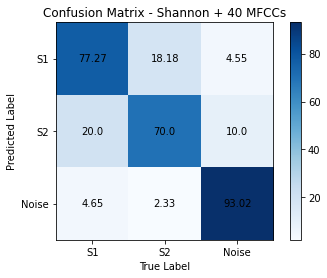

In [20]:
fig, ax = plt.subplots()

ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')

ticks = [0, 1, 2]
labels = ["S1", "S2", "Noise"]
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)
plt.title('Confusion Matrix - Shannon + '+str(n_mfccs)+' MFCCs')

for i in range(3):
    for j in range(3):
        c = matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
        
plt.imshow(matrix, cmap='Blues')
plt.colorbar() 

In [21]:
fig.savefig('../images/confusionMatrix/'+str(num_epochs)+'Epoch_shannon_mfccs'+str(n_mfccs)+'.jpg')

### Plot of model performance

In [22]:
history = pd.read_csv('../model_save/cut_setA_Train_shannon_mffcs'+str(n_mfccs)+'_Hist_'+str(num_epochs)+'.log')
history.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.387500,18.223198,0.25000,5.182140
1,1,0.421875,10.182417,0.46250,2.284317
2,2,0.429688,6.334516,0.64375,1.043067
3,3,0.465625,4.159179,0.58125,0.948349
4,4,0.448438,3.478678,0.60000,0.829265


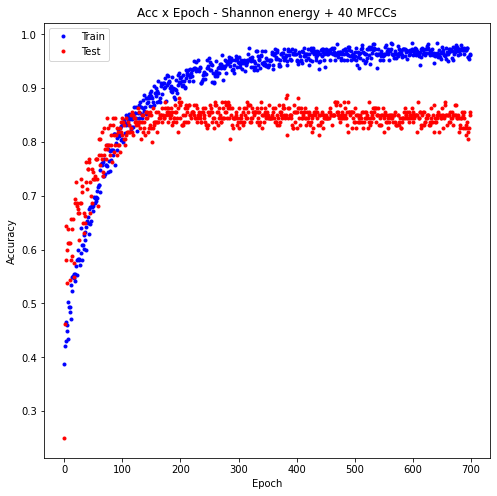

In [23]:
xx = np.array(history.epoch.tolist())
yy = np.array(history.accuracy.tolist())

fig = plt.figure(figsize=(8,8))
Plot = fig.add_subplot(111)
# Plots the accuracy x epoch for train
Plot.plot(xx, yy, "b.", label = 'Train')

yy = np.array(history.val_accuracy.tolist())
# Plots the accuracy x epoch for test
Plot.plot(xx, yy, "r.", label = 'Test')

Plot.title.set_text("Acc x Epoch - Shannon energy + "+str(n_mfccs)+" MFCCs")
Plot.set_xlabel("Epoch")
Plot.set_ylabel("Accuracy")
Plot.legend()

In [24]:
fig.savefig('../images/performance/'+str(num_epochs)+'Epoch_shannon_mfccs'+str(n_mfccs)+'.jpg')

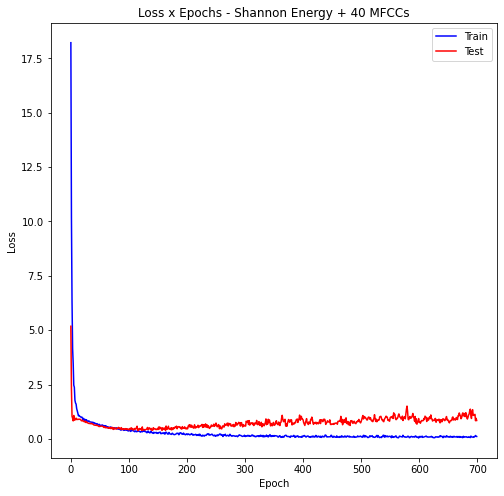

In [25]:
xx = np.array(history.epoch.tolist())
yy = np.array(history.loss.tolist())

fig = plt.figure(figsize=(8,8))
Plot = fig.add_subplot(111)
# Plots the loss x epoch for train
Plot.plot(xx, yy, "b-", label = 'Train')

yy = np.array(history.val_loss.tolist())
# Plots the loss x epoch for test
Plot.plot(xx, yy, "r-", label = 'Test')

Plot.title.set_text("Loss x Epochs - Shannon Energy + "+str(n_mfccs)+" MFCCs")
Plot.set_xlabel("Epoch")
Plot.set_ylabel("Loss")
Plot.legend()

In [26]:
fig.savefig('../images/performance/'+str(num_epochs)+'Epoch_shannon_mfccs'+str(n_mfccs)+'_loss.jpg')

In [27]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/negromontebs/seta/1c1d1228c6444e5080f9194fee1485d0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [700]                : (0.38749998807907104, 0.984375)
COMET INFO:     batch_accuracy [1400]         : (0.28125, 1.0)
COMET INFO:     batch_loss [1400]             : (0.0011756183812394738, 20.33049774169922)
COMET INFO:     epoch_duration [700]          : (0.07889720000093803, 8.643116200000804)
COMET INFO:     loss [700]                    : (0.041523974388837814, 18.22319793701172)
COMET INFO:     val_accuracy [700]            : (0.25, 0.887499988079071)
COMET INFO:     val_loss [700]                : (0.3831943869590759, 5.182140350341797)
COMET INFO:     validate_batch_accuracy [700] : (0.21875, 0.84375)
COMET INFO:     valida